# Importacion de bibliotecas

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#modelos y métricas
# import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import tree
# preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Cross validation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


#Modelado
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing

# Carga de datos

Creamos una copia del dataset para comenzar a trabajar

In [2]:
ds_hotel=pd.read_csv('./hotels_train_filtrado3.csv')
# ds_hotel = pd.read_csv("https://drive.google.com/uc?id=17TNcgVnEWVsnc5lwM8lFXJx2nVJHlnQpPpDZkdLSi9g")
# ds_hotel = pd.read_csv("https://drive.google.com/file/d/1YZv9nXnHTNsbhZNym-mYPxlUXMoTHcYe/view?usp=sharing")
#https://drive.google.com/file/d/1YZv9nXnHTNsbhZNym-mYPxlUXMoTHcYe/view?usp=sharing
ds_trabajo = ds_hotel.copy()

In [3]:
ds_trabajo = ds_trabajo.drop('adr_group',axis=1)
ds_trabajo = ds_trabajo.drop('score',axis=1)

In [4]:
# ONE HOT ENCODING ...
ds_trabajo_encoded = pd.get_dummies(ds_trabajo, columns=['hotel',
                                                 'market_segment',
                                                 'distribution_channel',
                                                 'is_repeated_guest',
                                                 'deposit_type',
                                                 'customer_type',
                                                 'agent_specified',
                                                 'more_than_zero_days_in_waiting_list',
                                                 'season',
                                                 'region',
                                                 'room_type_match'], drop_first=True)
ds_trabajo_encoded.head()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,previous_cancellations,previous_bookings_not_canceled,booking_changes,adr,total_of_special_requests,is_canceled,arrival_date,...,agent_specified_1,more_than_zero_days_in_waiting_list_1,season_Spring,season_Summer,season_Winter,region_Americas,region_Asia,region_Europe,region_Oceania,room_type_match_True
0,1.633333,1.0,2.0,0.0,0,0,115.5,1,1,1.473034e+09,...,1,0,0,1,0,1,0,0,0,1
1,0.133333,0.0,1.0,0.0,0,0,42.0,0,0,1.446250e+09,...,0,0,0,0,0,0,0,1,0,1
2,0.833333,0.0,1.0,0.0,0,0,229.0,2,0,1.476317e+09,...,1,0,0,0,0,0,0,1,0,1
3,0.866667,2.0,5.0,0.0,0,0,75.0,0,1,1.481501e+09,...,1,0,0,0,0,0,0,1,0,1
4,3.466667,2.0,5.0,0.0,0,0,75.0,1,0,1.489882e+09,...,1,0,0,0,1,0,0,1,0,1


Armamos una función para mostrar las métricas y la matriz de confusión de nuestas predicciones.

In [6]:
def mostrar_metricas(y_test, y_pred):
  print(classification_report(y_test,y_pred))

  # Calcular las métricas de evaluación
  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  # Imprimir las métricas de evaluación
  print("Accuracy:", accuracy)
  print("Recall:", recall)
  print("Precision:", precision)
  print("f1 score:", f1)

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

# Modelo KNN

## Construcción de clasificador KNN


In [6]:
ds_trabajo_encoded.columns

Index(['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes', 'adr', 'total_of_special_requests', 'is_canceled',
       'arrival_date', 'total_guests', 'hotel_Resort Hotel',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA', 'market_segment_Others',
       'distribution_channel_Direct', 'distribution_channel_GDS',
       'distribution_channel_TA/TO', 'is_repeated_guest_1',
       'deposit_type_Non Refund', 'customer_type_Transient',
       'customer_type_Transient-Party', 'agent_specified_1',
       'more_than_zero_days_in_waiting_list_1', 'season_Spring',
       'season_Summer', 'season_Winter', 'region_Americas', 'region_Asia',
       'region_Europe', 'region_Oceania', 'room_type_match_True'],
      dtype='object')

In [7]:
#Creo un dataset con los features que voy a usar para clasificar
ds_trabajo_x=ds_trabajo_encoded.drop(['is_canceled'], axis='columns')

#Creo un dataset con la variable target
ds_trabajo_y = ds_trabajo_encoded['is_canceled'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

In [8]:
# Establecer una semilla para reproducibilidad
np.random.seed(42)


#Crear el modelo
KNN_Classifier = KNeighborsClassifier(n_neighbors=5)
#vemos sus parámetros
KNN_Classifier.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [9]:
#Entrenar el modelo
KNN_Classifier.fit(x_train, y_train)

#Predicción sobre test
y_pred = KNN_Classifier.predict(x_test)

In [10]:
#Cantidad de aciertos
print('correctas: ', np.sum(y_test == y_pred))
print('total: ', len(y_test))

correctas:  11950
total:  18573


In [11]:
accuracy_score(y_test,y_pred)

0.6434070963226188

Vamos a observar distintos rangos para k vecinos y observar su comportamiento respecto del accuracy.

In [12]:
# from sklearn.model_selection import cross_val_score

# k_range=range(1,100) #cantidad de vecinos a probar

# k_scores=[] # accuracy para cada K utilizado

# for k in k_range:
#     #clasificador Knn
#     knn=KNeighborsClassifier(n_neighbors=k)
#     #uso 10 folds
#     scores=cross_val_score(knn,x_train,y_train,cv=10,scoring='accuracy')
#     #promedio las 10 métricas
#     k_scores.append(scores.mean())

In [13]:
# plt.plot(k_range, k_scores)
# plt.xlabel('Cantidad de Vecinos')
# plt.xticks(range(1,101,5))
# plt.ylabel('Cross Validation Accuracy')
# plt.title('Accuracy vs Cantidad de Vecinos')
# plt.show()

Nota: corrimos el código de arriba con distintos rangos para k, probamos valores en el rango de 0 a 2000 en distintas ejecuciones y notamos que las precisiones que se obtienen a mayor k son cercanas a 55% para todos estos casos. Por una cuestión de tiempos de ejecución elevados, decidimos dejar de probar valores para k más altos. Por el mismo motivo, dejaremos comentado el código (tarda en ejecutarse aprox. 13 minutos) y, en su lugar, dejaremos el gráfico de precisión vs accuracy para k entre 1 y 100 (en esta iteración hallamos el k más preciso) y las conclusiones pertinentes.

Podemos observar en el gráfico que el pico de precisión se alcanza cuando se observan entre 5 y 10 vecinos más cercanos. Tomaremos este rango para optimizar el hiperparámetro k.

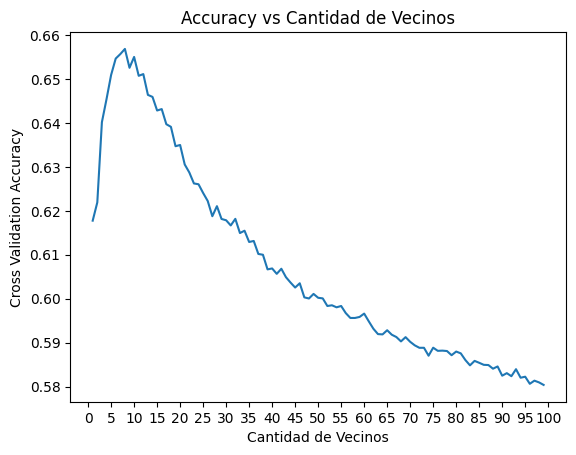

## Optimización de Hiperparámetros

Buscamos optimizar hiperparámetros para llevar nuestra predicción para mejorar el piso de 0.65 obtenido sin optimización. En primer lugar, vamos a ver las distancias que admite cada algoritmo.

In [14]:
from sklearn.metrics.pairwise import PAIRWISE_DISTANCE_FUNCTIONS
from sklearn.neighbors import BallTree
from sklearn.neighbors import KDTree

#Métricas Válidas
VALID_METRICS = dict(
    ball_tree=BallTree.valid_metrics,
    kd_tree=KDTree.valid_metrics,
    # The following list comes from the sklearn.metrics.pairwise doc string
    brute=list(PAIRWISE_DISTANCE_FUNCTIONS.keys())
    + [ 'braycurtis','canberra','chebyshev','correlation',
        'cosine','dice','hamming','jaccard','kulsinski',
        'mahalanobis','matching','minkowski','rogerstanimoto',
        'russellrao','seuclidean','sokalmichener','sokalsneath',
        'sqeuclidean','yule','wminkowski',
    ],
)

#Ejemplo
for alg in VALID_METRICS:
    print(f'algoritmo: {alg}')
    print(VALID_METRICS[alg])
    print()

algoritmo: ball_tree
['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity', 'seuclidean', 'mahalanobis', 'wminkowski', 'hamming', 'canberra', 'braycurtis', 'matching', 'jaccard', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'haversine', 'pyfunc']

algoritmo: kd_tree
['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity']

algoritmo: brute
['cityblock', 'cosine', 'euclidean', 'haversine', 'l2', 'l1', 'manhattan', 'precomputed', 'nan_euclidean', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine', 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule', 'wminkowski']



### Primera iteración (3 algoritmos, 3 métricas comunes)

Vamos a hacer una primera iteración de optimización de hiperparámetros, optimizando accuracy. Dejamos fijo el rango de k vecinos por el motivo anteriormente enunciado. Vamos a hacer 10 iteraciones de random search para los 3 algoritmos posibles y con 3 métricas comunes a todos ellos.

In [15]:
from sklearn.model_selection import RandomizedSearchCV

#Grilla de Parámetros
params_grid={ 'n_neighbors':range(5, 11), # rango para k de 5 a 10
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='f1', n_iter=10, random_state=5)

rand.fit(x_train, y_train)
rand.cv_results_['mean_test_score']

array([0.69358537, 0.71621313, 0.72604608, 0.65744423, 0.65119793,
       0.72723059, 0.71530206, 0.72596656, 0.7094352 , 0.71045665])

In [16]:
#Mejores hiperparametros
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'weights': 'distance', 'n_neighbors': 8, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
0.7272305908453414


Obtuvimos un nuevo piso de 0.73 con 9 vecinos, ponderando distancias y utilizando el algoritmo de ball tree midiendo distancias con Manhattan. En particular, vemos que todas las métricas rondan 0.73. 

In [17]:
#Mejor estimador
best_knn=rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_knn.predict(x_test)

#Accuracy test
accuracy_score(y_test,y_pred)

0.7358531201206052

In [18]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Obtener el mejor modelo ajustado por GridSearchCV
best_model = rand.best_estimator_

# Realizar predicciones sobre los datos de prueba
y_pred = best_model.predict(x_test)

# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("f1 score:", f1)


Accuracy: 0.7358531201206052
Recall: 0.7441885263382384
Precision: 0.7357157916930213
f1 score: 0.7399279050042409


              precision    recall  f1-score   support

           0       0.74      0.73      0.73      9195
           1       0.74      0.74      0.74      9378

    accuracy                           0.74     18573
   macro avg       0.74      0.74      0.74     18573
weighted avg       0.74      0.74      0.74     18573



Text(50.722222222222214, 0.5, 'True')

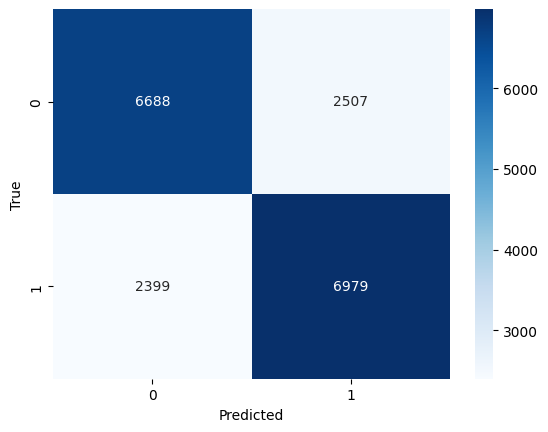

In [19]:
from sklearn.metrics import confusion_matrix,classification_report

#Reporte de Clasificación
print(classification_report(y_test,y_pred))

#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

### Segunda iteración (algoritmo kd tree, 5 de sus métricas posibles)

Ahora vamos a probar una iteración para optimizar hiperparámetros con kd tree y algunas de sus métricas.

In [20]:
from sklearn.model_selection import RandomizedSearchCV

#Grilla de Parámetros
params_grid={ 'n_neighbors':range(5, 11), # rango para k de 5 a 10
              'weights':['distance','uniform'],
              'algorithm':['kd_tree'],
              'metric':['euclidean', 'l2', 'minkowski', 'p', 'manhattan']
             }

#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='f1', n_iter=10, random_state=2)

rand.fit(x_train, y_train)
rand.cv_results_['mean_test_score']

array([0.71343838, 0.71343838, 0.64786677, 0.66404868, 0.64786677,
       0.71628932, 0.64786677, 0.714647  , 0.69398462, 0.71542499])

In [21]:
#Mejores hiperparametros
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'weights': 'distance', 'n_neighbors': 10, 'metric': 'p', 'algorithm': 'kd_tree'}
0.7162893219535658


Obtuvimos como mejores hiperparámetros para el algoritmo kd tree la métrica cityblock y 7 vecinos cercanos. Ha empeorado la métrica respecto de la iteración anterior.

In [22]:
#Mejor estimador
best_knn=rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_knn.predict(x_test)

#Accuracy test
accuracy_score(y_test,y_pred)

0.725569374899047

In [23]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Obtener el mejor modelo ajustado por GridSearchCV
best_model = rand.best_estimator_

# Realizar predicciones sobre los datos de prueba
y_pred = best_model.predict(x_test)

# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("f1 score:", f1)


Accuracy: 0.725569374899047
Recall: 0.7239283429302623
Precision: 0.7302355598580187
f1 score: 0.7270682730923695


              precision    recall  f1-score   support

           0       0.72      0.73      0.72      9195
           1       0.73      0.72      0.73      9378

    accuracy                           0.73     18573
   macro avg       0.73      0.73      0.73     18573
weighted avg       0.73      0.73      0.73     18573



Text(50.722222222222214, 0.5, 'True')

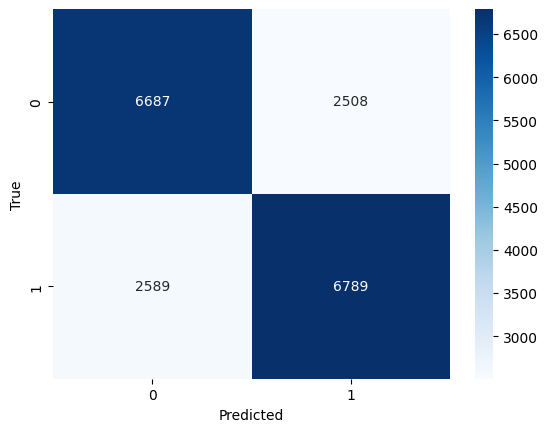

In [24]:
from sklearn.metrics import confusion_matrix,classification_report

#Reporte de Clasificación
print(classification_report(y_test,y_pred))

#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

### Tercera iteración (algoritmo kd tree, 4 de sus métricas posibles)

Probaremos otras métricas para kd tree.

In [25]:
from sklearn.model_selection import RandomizedSearchCV

#Grilla de Parámetros
params_grid={ 'n_neighbors':range(5, 11), # rango para k de 5 a 10
              'weights':['distance','uniform'],
              'algorithm':['kd_tree'],
              'metric':['cityblock', 'l1', 'chebyshev', 'infinity']
             }

#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='f1', n_iter=10, random_state=2)

rand.fit(x_train, y_train)
rand.cv_results_['mean_test_score']

array([0.65749406, 0.72593777, 0.71045665, 0.72669184, 0.64331868,
       0.64709881, 0.71140482, 0.69398462, 0.72639585, 0.72593777])

In [26]:
#Mejores hiperparametros
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'weights': 'distance', 'n_neighbors': 7, 'metric': 'l1', 'algorithm': 'kd_tree'}
0.7266918432133327


Logramos un porcentaje de precisión similar al de la primera iteración.

In [27]:
#Mejor estimador
best_knn=rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_knn.predict(x_test)

#Accuracy test
accuracy_score(y_test,y_pred)

0.7350993377483444

In [28]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Obtener el mejor modelo ajustado por GridSearchCV
best_model = rand.best_estimator_

# Realizar predicciones sobre los datos de prueba
y_pred = best_model.predict(x_test)

# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("f1 score:", f1)


Accuracy: 0.7350993377483444
Recall: 0.7463211772232885
Precision: 0.7336477987421384
f1 score: 0.739930225182366


              precision    recall  f1-score   support

           0       0.74      0.72      0.73      9195
           1       0.73      0.75      0.74      9378

    accuracy                           0.74     18573
   macro avg       0.74      0.73      0.74     18573
weighted avg       0.74      0.74      0.74     18573



Text(50.722222222222214, 0.5, 'True')

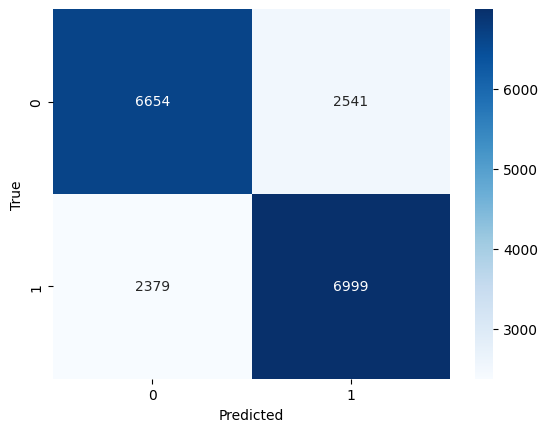

In [29]:
from sklearn.metrics import confusion_matrix,classification_report

#Reporte de Clasificación
print(classification_report(y_test,y_pred))

#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

### Cuarta iteración (algoritmo ball tree, 7 de sus métricas posibles)

Ahora vamos a hacer otras iteraciones para optimizar hiperparámetros, esta vez con ball tree y 7 de sus métricas posibles.

In [30]:
from sklearn.model_selection import RandomizedSearchCV

#Grilla de Parámetros
params_grid={ 'n_neighbors':range(5, 11), # rango para k de 5 a 10
              'weights':['distance','uniform'],
              'algorithm':['ball_tree'],
              'metric':['euclidean', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'infinity']
             }

#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='f1', n_iter=10, random_state=2)

rand.fit(x_train, y_train)
rand.cv_results_['mean_test_score']

array([0.64779951, 0.71350112, 0.67068701, 0.71466402, 0.71045919,
       0.65744423, 0.71316128, 0.67351006, 0.64707198, 0.7265248 ])

In [31]:
#Mejores hiperparametros
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'weights': 'distance', 'n_neighbors': 6, 'metric': 'l1', 'algorithm': 'ball_tree'}
0.7265248033498228


La precisión sigue siendo similar al de iteraciones anteriores, 73%.

In [32]:
#Mejor estimador
best_knn=rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_knn.predict(x_test)

#Accuracy test
accuracy_score(y_test,y_pred)

0.7350993377483444

In [33]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Obtener el mejor modelo ajustado por GridSearchCV
best_model = rand.best_estimator_

# Realizar predicciones sobre los datos de prueba
y_pred = best_model.predict(x_test)

# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("f1 score:", f1)


Accuracy: 0.7350993377483444
Recall: 0.7452548517807634
Precision: 0.7341386554621848
f1 score: 0.739654989946026


              precision    recall  f1-score   support

           0       0.74      0.72      0.73      9195
           1       0.73      0.75      0.74      9378

    accuracy                           0.74     18573
   macro avg       0.74      0.73      0.74     18573
weighted avg       0.74      0.74      0.74     18573



Text(50.722222222222214, 0.5, 'True')

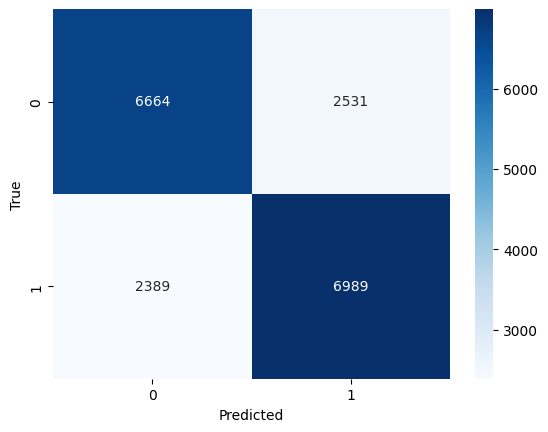

In [34]:
from sklearn.metrics import confusion_matrix,classification_report

#Reporte de Clasificación
print(classification_report(y_test,y_pred))

#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

### Quinta iteración (algoritmo ball tree, 4 de sus métricas posibles)

Probaremos optimizar otras métricas para el algoritmo ball tree.

In [35]:
# from sklearn.model_selection import RandomizedSearchCV

# #Grilla de Parámetros
# params_grid={ 'n_neighbors':range(5, 11), # rango para k de 5 a 10
#               'weights':['distance','uniform'],
#               'algorithm':['ball_tree'],
#               'metric':['hamming', 'jaccard', 'chebyshev', 'l1']
#              }

# #Clasificador KNN
# knn=KNeighborsClassifier()

# #Random Search con 10 Folds y 10 iteraciones
# rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='f1', n_iter=10, random_state=2)

# rand.fit(x_train, y_train)
# rand.cv_results_['mean_test_score']

In [36]:
# #Mejores hiperparametros
# print(rand.best_params_)
# #Mejor métrica
# print(rand.best_score_)

In [37]:
#Mejor estimador
best_knn=rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_knn.predict(x_test)

#Accuracy test
accuracy_score(y_test,y_pred)

0.7350993377483444

In [38]:
# from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# # Obtener el mejor modelo ajustado por GridSearchCV
# best_model = rand.best_estimator_

# # Realizar predicciones sobre los datos de prueba
# y_pred = best_model.predict(x_test)

# # Calcular las métricas de evaluación
# accuracy = accuracy_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# # Imprimir las métricas de evaluación
# print("Accuracy:", accuracy)
# print("Recall:", recall)
# print("Precision:", precision)
# print("f1 score:", f1)


In [39]:
# from sklearn.metrics import confusion_matrix,classification_report

# #Reporte de Clasificación
# print(classification_report(y_test,y_pred))

# #Matriz de Confusión
# cm = confusion_matrix(y_test,y_pred)
# sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
# plt.xlabel('Predicted')
# plt.ylabel('True')

Nota: esta quinta iteración tardó cerca de 40min en ejecutarse, por este motivo vamos a dejar comentado el random search y vamos a generar el clasificador y mostrar las métricas con los hiperparámetros optimizados. Obtuvimos, como mejores hiperparámetros, distancias ponderadas, 5 vecinos cercanos, métrica de hamming y algoritmo de ball tree. Logramos un 79% de precisión.

In [40]:
knn=KNeighborsClassifier(weights="distance", n_neighbors=5, metric="hamming", algorithm="ball_tree")
knn.get_params()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
#Cantidad de aciertos
print('correctas: ', np.sum(y_test == y_pred))
print('total: ', len(y_test))
accuracy_score(y_test,y_pred)


correctas:  14889
total:  18573


0.8016475528993701

In [41]:
# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("f1 score:", f1)

Accuracy: 0.8016475528993701
Recall: 0.7682874813393048
Precision: 0.8266406608536025
f1 score: 0.7963965955565381


              precision    recall  f1-score   support

           0       0.78      0.84      0.81      9195
           1       0.83      0.77      0.80      9378

    accuracy                           0.80     18573
   macro avg       0.80      0.80      0.80     18573
weighted avg       0.80      0.80      0.80     18573



Text(50.722222222222214, 0.5, 'True')

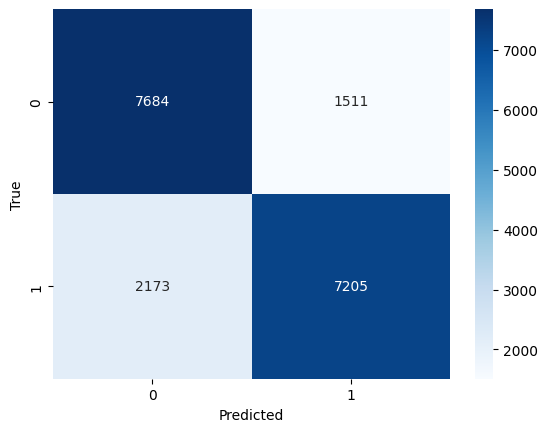

In [42]:
from sklearn.metrics import confusion_matrix,classification_report

#Reporte de Clasificación
print(classification_report(y_test,y_pred))

#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

### Sexta iteración (algoritmo brute)

En esta iteración, probaremos el algoritmo brute con métricas 'cosine', 'haversine', 'canberra', 'chebyshev', 'correlation' para optimizar hiperparámetros.

In [43]:
from sklearn.model_selection import RandomizedSearchCV

#Grilla de Parámetros
params_grid={ 'n_neighbors':range(5, 11), # rango para k de 5 a 10
              'weights':['distance','uniform'],
              'algorithm':['brute'],
              'metric':['cosine', 'haversine', 'canberra', 'chebyshev', 'correlation']
             }

#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='f1', n_iter=10, random_state=2)

rand.fit(x_train, y_train)
rand.cv_results_['mean_test_score']

array([0.70878949, 0.49511434, 0.64331739, 0.43785483,        nan,
       0.71075824, 0.78138656, 0.80585785, 0.51326515, 0.80799601])

In [44]:
#Mejores hiperparametros
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'weights': 'distance', 'n_neighbors': 9, 'metric': 'canberra', 'algorithm': 'brute'}
0.8079960114410099


Obtuvimos como mejores hiperparámetros con brute la métrica canberra y 9 vecinos cercanos. Obtuvimos un 81% de precisión, siendo esta la mejor obtenida hasta el momento con KNN.

In [45]:
#Mejor estimador
best_knn=rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_knn.predict(x_test)

#Accuracy test
accuracy_score(y_test,y_pred)

0.8146772196198783

In [46]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Obtener el mejor modelo ajustado por GridSearchCV
best_model = rand.best_estimator_

# Realizar predicciones sobre los datos de prueba
y_pred = best_model.predict(x_test)

# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("f1 score:", f1)


Accuracy: 0.8146772196198783
Recall: 0.8058221369161869
Precision: 0.8233820004358248
f1 score: 0.8145074369476181


              precision    recall  f1-score   support

           0       0.81      0.82      0.81      9195
           1       0.82      0.81      0.81      9378

    accuracy                           0.81     18573
   macro avg       0.81      0.81      0.81     18573
weighted avg       0.81      0.81      0.81     18573



Text(50.722222222222214, 0.5, 'True')

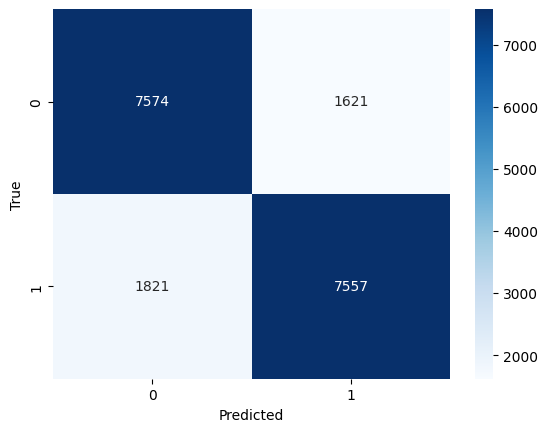

In [47]:
from sklearn.metrics import confusion_matrix,classification_report

#Reporte de Clasificación
print(classification_report(y_test,y_pred))

#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

## Análisis de las métricas de los mejores hiperparámetros hallados y generación del modelo para KNN

Dadas las iteraciones mostradas anteriormente, nos quedaremos con la sexta ya que tiene las mejores métricas. A continuación, mostraremos las mismas y su matriz de confusión para hacer un análisis de nuestro clasificador KNN.

In [48]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

best_knn=KNeighborsClassifier(weights="distance", n_neighbors=9, metric="canberra", algorithm="brute")
best_knn.get_params()
best_knn.fit(x_train, y_train)
y_pred = best_knn.predict(x_test)
#Cantidad de aciertos
print('correctas:', np.sum(y_test == y_pred))
print('total:', len(y_test))
# accuracy_score(y_test,y_pred)


# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("f1 score:", f1)

correctas: 15131
total: 18573
Accuracy: 0.8146772196198783
Recall: 0.8058221369161869
Precision: 0.8233820004358248
f1 score: 0.8145074369476181


              precision    recall  f1-score   support

           0       0.81      0.82      0.81      9195
           1       0.82      0.81      0.81      9378

    accuracy                           0.81     18573
   macro avg       0.81      0.81      0.81     18573
weighted avg       0.81      0.81      0.81     18573



Text(50.722222222222214, 0.5, 'True')

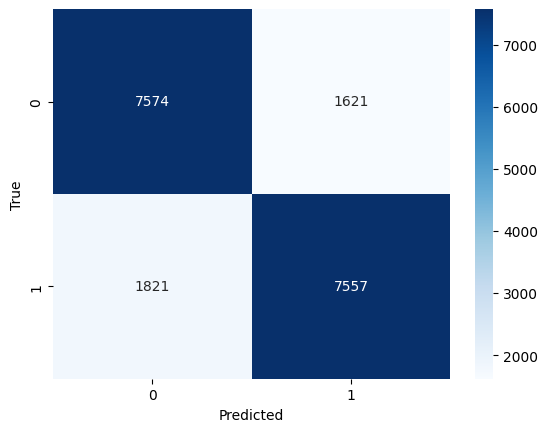

In [49]:
from sklearn.metrics import confusion_matrix,classification_report

#Reporte de Clasificación
print(classification_report(y_test,y_pred))

#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

El modelo ha predicho correctamente la cancelación o no-cancelación de la reserva en un 81,57%, dada su accuracy. Además, según el recall obtenido, el modelo identifica correctamente el 80,80% de todas las cancelaciones de reservas en el conjunto de datos. El precision del modelo es del 82,38%, lo que significa que, de todas las predicciones que hizo el modelo de que la reserva sería cancelada, el 82,38% de ellas son realmente cancelaciones. Finalmente, el valor de f1-score es del 81,58%.

Exportamos el modelo en formato pickle.

In [50]:
import pickle

with open('models/knn/knn_model.pickle', 'wb') as archivo:
    pickle.dump(best_knn, archivo)

# Modelo SVM

Vamos a normalizar los datos para obtener un conjunto con desviación estándar unitaria para cada característica y obtener una buena predicción

In [51]:
#Creo un dataset con los features que voy a usar para clasificar
ds_trabajo_x=ds_trabajo_encoded.drop(['is_canceled'], axis='columns')

#Creo un dataset con la variable target
ds_trabajo_y = ds_trabajo_encoded['is_canceled'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

#Armo una version escalada con minmax (media=0 , var=1  )
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train) 
x_test_minmax  = min_max_scaler.transform(x_test) 

#Armo una version estandarizada
stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm=stand_scaler.transform(x_test)

Vamos a probar entrenar un modelo SVM con los datos escalados con normalización y con minmax, y veremos cuál tiene mejores métricas para trabajar con eso.

In [52]:
#Construyo un modelo SVM  
svm_norm= SVC()

#Lo entreno con los datos escalados con normalizacion
svm_norm.fit(x_train_norm, y_train)

#Hago la prediccion y calculo las métricas
y_pred_norm=svm_norm.predict(x_test_norm)

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      9195
           1       0.84      0.76      0.80      9378

    accuracy                           0.80     18573
   macro avg       0.81      0.80      0.80     18573
weighted avg       0.81      0.80      0.80     18573

Accuracy: 0.8040704248102084
Recall: 0.7570910641927916
Precision: 0.8391443091833116
f1 score: 0.7960087448848029


Text(50.722222222222214, 0.5, 'True')

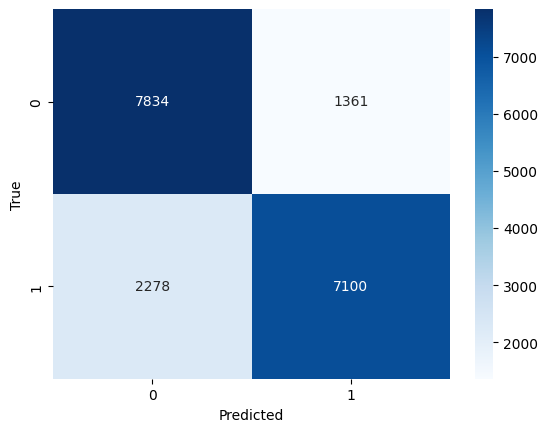

In [53]:
print(classification_report(y_test,y_pred_norm))

# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred_norm)
recall = recall_score(y_test, y_pred_norm)
precision = precision_score(y_test, y_pred_norm)
f1 = f1_score(y_test, y_pred_norm)

# Imprimir las métricas de evaluación
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("f1 score:", f1)

cm = confusion_matrix(y_test,y_pred_norm)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [54]:
# #Construyo un modelo SVM  
# svm_minmax= SVC()

# #Lo entreno con los datos escalados con min max
# svm_minmax.fit(x_train_minmax, y_train)

# #Hago la prediccion y calculo las métricas
# y_pred_minmax=svm_minmax.predict(x_test_minmax)

In [55]:
# mostrar_metricas(y_test, y_pred_minmax)

La predicción con el escalado normalizado fue mejor que con el minmax, vamos a utilizar entonces los datos normalizados para optimizar hiperparámetros.:

Ahora vamos a aplicar PCA para reducir la dimensionalidad de nuestro problema. 

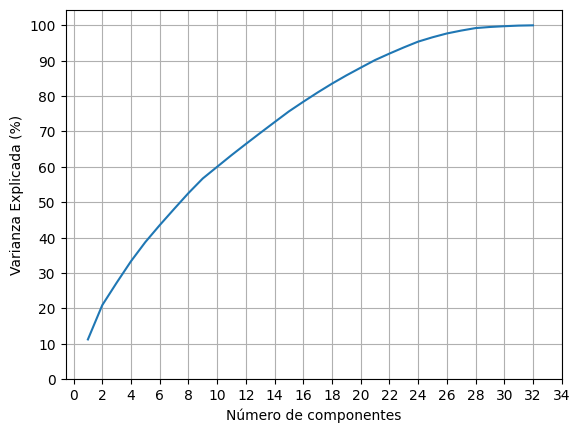

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# PCA sobre los datos escalados
pca = PCA(n_components = None)
pca.fit(x_train_norm)

#Cantidad de Componentes
componentes = len(pca.explained_variance_ratio_) 

#Grafico la Varianza Explicada 
plt.plot(range(1,componentes+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Número de componentes")
plt.xticks(range(0,36,2))
plt.yticks(range(0,101,10))
plt.ylabel("Varianza Explicada (%)")
# Agregar una grilla al gráfico
plt.grid()
plt.show()

En el gráfico vemos que con los primeros 20 componentes principales se explica casi el 90% de la variabilidad de los datos.

Probaremos entrenar una SVM tomando sólo esas primeras 20 componentes.

              precision    recall  f1-score   support

           0       0.85      0.76      0.80     10159
           1       0.75      0.83      0.79      8414

    accuracy                           0.79     18573
   macro avg       0.80      0.80      0.79     18573
weighted avg       0.80      0.79      0.80     18573

Accuracy: 0.7946481451569483
Recall: 0.8306394105062991
Precision: 0.7452548517807634
f1 score: 0.7856339928057553


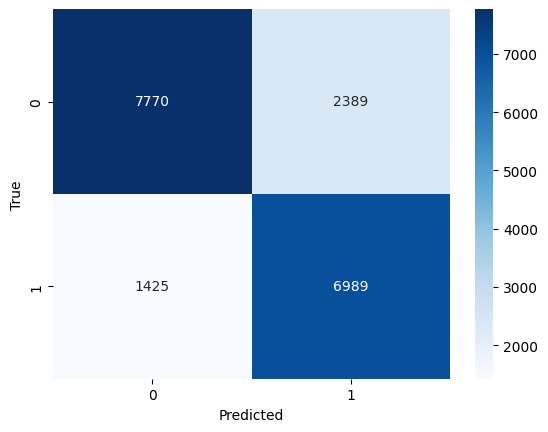

In [57]:
from sklearn.pipeline import Pipeline

#Defino el tipo de escalado, la transformacion PCA y el modelo
_sc = StandardScaler()
_pca = PCA(n_components = 20)
_model = SVC()

#Creo un pipeline
svm_model = Pipeline([
    ('std_scaler', _sc),
    ('pca', _pca),
    ('svm', _model)
])

#Entreno sobre los datos que serán previamente escalados y transformados
svm_model.fit(x_train,y_train)

#Hago la predicción y calculo las métricas
y_pred_pca=svm_model.predict(x_test)
mostrar_metricas(y_pred_pca,y_test)

## SVM con Kernel Lineal

              precision    recall  f1-score   support

           0       0.75      0.74      0.75      9223
           1       0.75      0.75      0.75      9350

    accuracy                           0.75     18573
   macro avg       0.75      0.75      0.75     18573
weighted avg       0.75      0.75      0.75     18573

Accuracy: 0.7473752220965918
Recall: 0.7505882352941177
Precision: 0.7483471955640861
f1 score: 0.7494660401537805


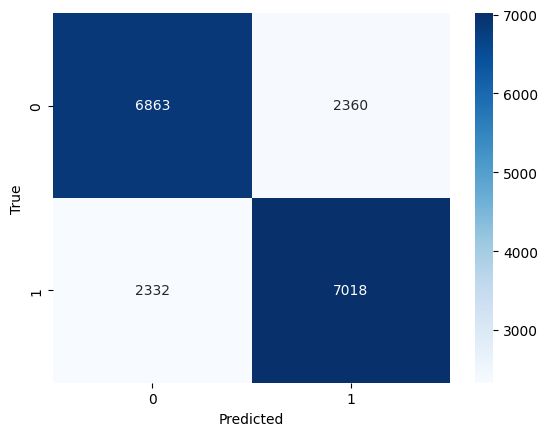

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

#Defino el tipo de escalado y la transformacion PCA
_sc = StandardScaler()
_pca = PCA(n_components = 20)

#Creo un pipeline con escalado y reducción de dimensionalidad
pca_pipe = Pipeline([
    ('std_scaler', _sc),
    ('pca', _pca)
])

#Aplico el pipeline a los datos de entrenamiento
x_train_pca = pca_pipe.fit_transform(x_train_norm)

#Creo un clasificador con kernel lineal y lo entreno sobre los datos escalados min-max
clf = SVC(kernel='linear', C=8)

#Entreno el clasificador con los datos de entrenamiento reducidos de dimensionalidad
clf.fit(x_train_pca, y_train)

#Aplico el pipeline a los datos de prueba
x_test_pca = pca_pipe.transform(x_test_norm)

#Hago la predicción y calculo las métricas
y_pred_lin_pca = clf.predict(x_test_pca)
mostrar_metricas(y_pred_lin_pca, y_test)


## SVM con Kernel Radial

              precision    recall  f1-score   support

           0       0.88      0.73      0.80     11139
           1       0.68      0.85      0.76      7434

    accuracy                           0.78     18573
   macro avg       0.78      0.79      0.78     18573
weighted avg       0.80      0.78      0.78     18573

Accuracy: 0.778280299359285
Recall: 0.8537799300511165
Precision: 0.6767967583706547
f1 score: 0.7550559124434928


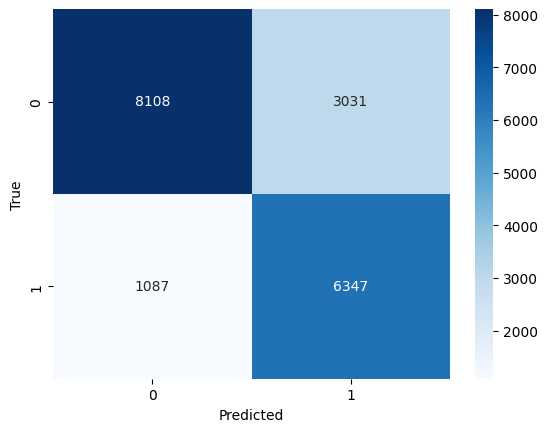

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

#Defino el tipo de escalado y la transformacion PCA
_sc = StandardScaler()
_pca = PCA(n_components = 20)

#Creo un pipeline con escalado y reducción de dimensionalidad
pca_pipe = Pipeline([
    ('std_scaler', _sc),
    ('pca', _pca)
])

#Aplico el pipeline a los datos de entrenamiento
x_train_pca = pca_pipe.fit_transform(x_train_norm)

clf = SVC(kernel='rbf', C=7, gamma=10)

#Entreno el clasificador con los datos de entrenamiento reducidos de dimensionalidad
clf.fit(x_train_pca, y_train)

#Aplico el pipeline a los datos de prueba
x_test_pca = pca_pipe.transform(x_test_norm)

#Hago la predicción y calculo las métricas
y_pred_lin_pca = clf.predict(x_test_pca)
mostrar_metricas(y_pred_lin_pca, y_test)


              precision    recall  f1-score   support

           0       0.90      0.71      0.80     11628
           1       0.64      0.87      0.74      6945

    accuracy                           0.77     18573
   macro avg       0.77      0.79      0.77     18573
weighted avg       0.80      0.77      0.77     18573

Accuracy: 0.770580950842621
Recall: 0.868394528437725
Precision: 0.6431008743868629
f1 score: 0.7389572995160204


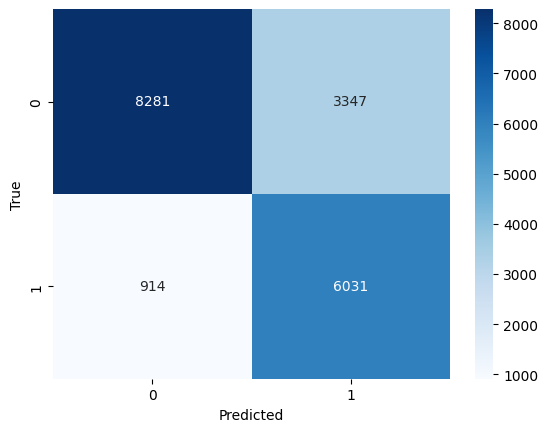

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

#Defino el tipo de escalado y la transformacion PCA
_sc = StandardScaler()
_pca = PCA(n_components = 20)

#Creo un pipeline con escalado y reducción de dimensionalidad
pca_pipe = Pipeline([
    ('std_scaler', _sc),
    ('pca', _pca)
])

#Aplico el pipeline a los datos de entrenamiento
x_train_pca = pca_pipe.fit_transform(x_train_norm)

clf = SVC(kernel='rbf', C=8, gamma=16)

#Entreno el clasificador con los datos de entrenamiento reducidos de dimensionalidad
clf.fit(x_train_pca, y_train)

#Aplico el pipeline a los datos de prueba
x_test_pca = pca_pipe.transform(x_test_norm)

#Hago la predicción y calculo las métricas
y_pred_lin_pca = clf.predict(x_test_pca)
mostrar_metricas(y_pred_lin_pca, y_test)


# Modelo RF

Nota 2 CB: lo estuve corriendo en colab todo el día, por una cuestión de tiempos subo esto a git sin correr para que tengan los últimos cambios. Igualmente las métricas logradas están por encima de 80% para todas ellas, los mejores hiperparámetros que fui consiguiendo los tengo separados para generar el modelo si no llego a conseguir mejores.

In [9]:
#Creo un dataset con los features que voy a usar para clasificar
ds_trabajo_x=ds_trabajo_encoded.drop(['is_canceled'], axis='columns')

#Creo un dataset con la variable target
ds_trabajo_y = ds_trabajo_encoded['is_canceled'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

Hacemos una primera predicción con la implementación default de RandomForest para establecer un piso de métricas

In [62]:
rfc = RandomForestClassifier()
#Entrenamos el modelo
model = rfc.fit(X = x_train, y = y_train)
#Predicción sobre test
y_pred = rfc.predict(x_test)

mostrar_metricas(y_test, y_pred)

Obtenemos unas buenas métricas con RF por default. Observando la importancia de características, vemos que el modelo considera importantes `lead_time`, `arrival_date` y `adr` principalmente.

In [63]:
sorted(list(zip(ds_trabajo_x.columns.to_list(), model.feature_importances_)), key=lambda x: -x[1])

[('lead_time', 0.1849510565848066),
 ('arrival_date', 0.1306847501748809),
 ('adr', 0.12362626065157883),
 ('deposit_type_Non Refund', 0.09628120399213834),
 ('total_of_special_requests', 0.06574669910951887),
 ('stays_in_week_nights', 0.05213808880119937),
 ('room_type_match_True', 0.044197428102856214),
 ('previous_cancellations', 0.03546366261868027),
 ('stays_in_weekend_nights', 0.03149471852473211),
 ('booking_changes', 0.028297172260298212),
 ('total_guests', 0.024886305007399318),
 ('market_segment_Online TA', 0.022002264611139105),
 ('market_segment_Groups', 0.01862919917732114),
 ('customer_type_Transient', 0.018188800500698262),
 ('customer_type_Transient-Party', 0.016030839243909092),
 ('hotel_Resort Hotel', 0.014811942976285155),
 ('market_segment_Offline TA/TO', 0.013166298511118828),
 ('distribution_channel_TA/TO', 0.01035828664269106),
 ('season_Spring', 0.008917498479437813),
 ('season_Summer', 0.008569109389600541),
 ('region_Europe', 0.008363502483255944),
 ('distribu

Ahora vamos a optimizar hiperparámetros intentando mejorar el F1 score.

In [64]:
rf_cv = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], 
               "min_samples_leaf" : range(1,15,2), 
               "min_samples_split" : range(2,21,2), 
               "n_estimators": [10,20,50,80] }

#Probamos entrenando sólo con 1 métrica
gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1)
gs_fit = gs.fit(X = x_train, y = y_train)

gs_fit.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 80}

In [65]:
#Obtenemos el mejor modelo
rf_cv_best=gs_fit.best_estimator_

#Predicción
y_pred = rf_cv_best.predict(x_test)

Analizamos las métricas

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      9195
           1       0.86      0.81      0.84      9378

    accuracy                           0.84     18573
   macro avg       0.84      0.84      0.84     18573
weighted avg       0.84      0.84      0.84     18573

Accuracy: 0.8405750282668389
Recall: 0.8141394753678822
Precision: 0.862419518807184
f1 score: 0.8375843343755143


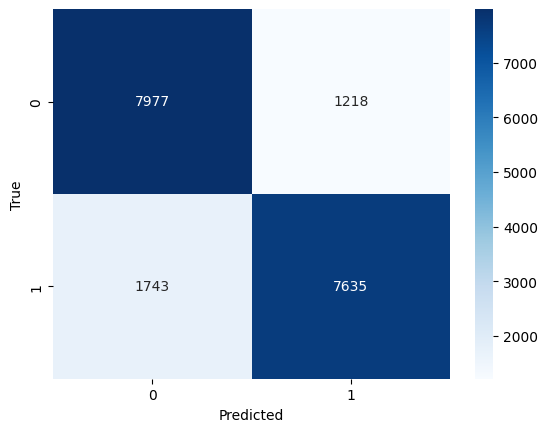

In [66]:
mostrar_metricas(y_test, y_pred)

Probamos optimización multi métrica

In [67]:
rf_cv = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], 
               "min_samples_leaf" : [1, 5, 10], 
               "min_samples_split" : [2, 4, 10, 12, 16], 
               "n_estimators": [10,20, 50, 80] }

#Probamos entrenando con varias métricas

metricas=['accuracy','f1','roc_auc'] #'recall','precision'

gs_multimetrica = GridSearchCV(estimator=rf_cv, 
                               param_grid=param_grid, 
                               scoring=metricas, 
                               refit=False, 
                               cv=5, 
                               n_jobs=-1)
#Entrenamiento
gs_multimetrica_fit = gs_multimetrica.fit(X = x_train, y = y_train)

Y graficamos los resultados

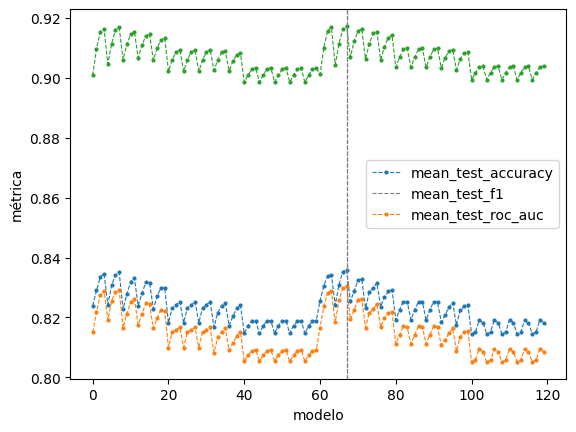

In [68]:
labels=[ key for key in gs_multimetrica_fit.cv_results_.keys() if("mean_test" in key)]

for k in labels:
    plt.plot(gs_multimetrica_fit.cv_results_[k],linestyle='--' , linewidth=0.8,marker='o',markersize=2)     
    x_linea=np.argmax(gs_multimetrica_fit.cv_results_[k])
    plt.axvline(x_linea,linestyle='--' ,linewidth=0.8,color='grey')
        
plt.xlabel("modelo", fontsize=10)
plt.ylabel("métrica", fontsize=10)
plt.legend(labels)
plt.show()

Realizamos una predicción

In [69]:
params_elegidos=gs_multimetrica_fit.cv_results_['params'][np.argmax(gs_multimetrica_fit.cv_results_['mean_test_f1'])]
params_elegidos

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 80}

In [70]:
#Creamos un clasificador RF
rfc_multimetrica = RandomForestClassifier(criterion= params_elegidos['criterion'], 
                                          min_samples_leaf= params_elegidos['min_samples_leaf'], 
                                          min_samples_split= params_elegidos['min_samples_split'], 
                                          n_estimators=params_elegidos['n_estimators'], 
                                          oob_score=True, random_state=2, n_jobs=-1)
#Entrenamos un modelo
model_rfc_multimetrica = rfc_multimetrica.fit(X = x_train, y = y_train)

#Hacemos una predicción
y_pred = model_rfc_multimetrica.predict(x_test)

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      9195
           1       0.86      0.82      0.84      9378

    accuracy                           0.84     18573
   macro avg       0.84      0.84      0.84     18573
weighted avg       0.84      0.84      0.84     18573

Accuracy: 0.8415980186291929
Recall: 0.81659202388569
Precision: 0.8623873873873874
f1 score: 0.8388651550005478


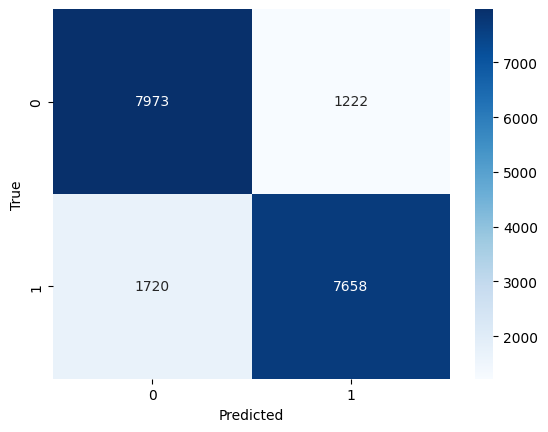

In [71]:
mostrar_metricas(y_test, y_pred)

## Análisis de las métricas de los mejores hiperparámetros hallados y generación del modelo para Random Forest

Basado en las siguientes métricas de evaluación, se puede concluir que el nuestro modelo Random Forest ha tenido un rendimiento satisfactorio en la clasificación. Las tasas de accuracy, recall y precision son altas, y el F1 score muestra que hay un equilibrio bueno entre precisión y recall, estando todas estas métricas por encima del 81%. Esto sugiere que el modelo es capaz de clasificar correctamente la mayoría de las instancias en el conjunto de datos de prueba. Además, el alto valor de área bajo la curva ROC, aproximadamente 92%, indica que el modelo tiene una capacidad de discriminación muy buena entre instancias positivas y negativas.

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      9195
           1       0.86      0.81      0.84      9378

    accuracy                           0.84     18573
   macro avg       0.84      0.84      0.84     18573
weighted avg       0.84      0.84      0.84     18573

Accuracy: 0.8416518602272115
Recall: 0.8141394753678822
Precision: 0.8643722404619042
f1 score: 0.8385042007577838


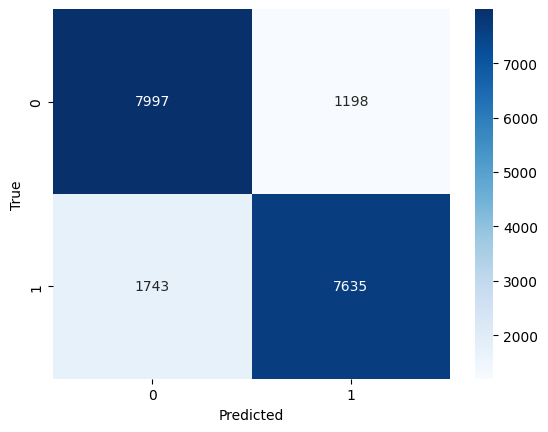

In [18]:
best_rf=RandomForestClassifier(criterion='entropy', min_samples_leaf=1 ,min_samples_split=4, n_estimators=80)
best_rf.get_params()
best_rf.fit(x_train, y_train)
y_pred = best_rf.predict(x_test)
mostrar_metricas(y_test, y_pred)

In [22]:
from sklearn.metrics import roc_auc_score
import pandas as pd
y_pred_proba = pd.Series(best_rf.predict_proba(x_test)[:, 1])
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('AUC-ROC:', roc_auc)

AUC-ROC: 0.9208029192847884


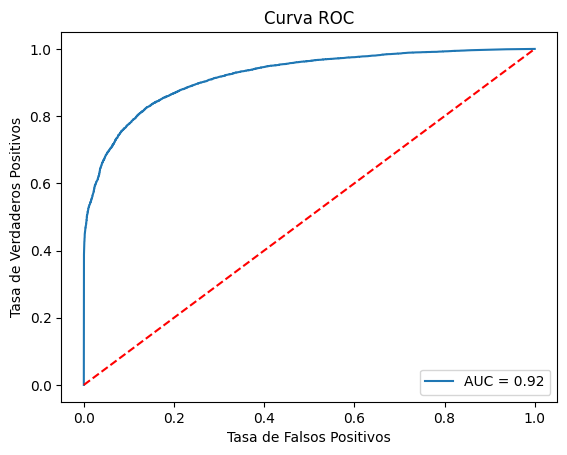

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Obtener las probabilidades de la clase positiva
y_probs = best_rf.predict_proba(x_test)[:,1]

# Calcular la curva ROC
fpr, tpr, umbrales = roc_curve(y_test, y_probs)

# Calcular el área bajo la curva ROC
auc = roc_auc_score(y_test, y_probs)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


Exportamos el modelo en formato pickle.

In [20]:
import pickle

with open('models/random_forest/rf_model.pickle', 'wb') as archivo:
    pickle.dump(best_rf, archivo)